In [1]:
import numpy as np
import torch
import torch.nn as nn
import transformers
import pandas as pd
import os
import json


In [2]:
def load_ECHR(path:str, anon:bool=False):

    """Load ECHR dataset from json to pandas dataframe

    Args:
        path (str): path to ECHR dataset
        anon (bool, optional): if True, load anonymized dataset. Defaults to False.

        Returns:
            df_train (pd.DataFrame): train dataset
            df_dev (pd.DataFrame): dev dataset
            df_test (pd.DataFrame): test dataset

    """

    # load train, dev and test dataset from json to pandas dataframe
    sfx = '_Anon' if anon else ''

    # define dataframe empty
    df_train = pd.DataFrame()
    df_dev = pd.DataFrame()
    df_test = pd.DataFrame()

    # train dataset
    train_path = path+'/EN_train'+sfx+'/'
    # for all the files in a directory
    for filename in os.listdir(train_path):
        with open(train_path+filename) as f:
            # add json to dataframe as a row
            data = json.load(f)
            df = pd.DataFrame.from_dict(data, orient='index').T
            df_train = df_train._append(df, ignore_index=True)

    # dev dataset
    dev_path = path+'/EN_dev'+sfx+'/'
    # for all the files in a directory
    for filename in os.listdir(dev_path):
        with open(dev_path+filename) as f:
            # add json to dataframe as a row
            data = json.load(f)
            df = pd.DataFrame.from_dict(data, orient='index').T
            df_dev = df_dev._append(df, ignore_index=True)

    # test dataset
    test_path = path+'/EN_test'+sfx+'/'
    # for all the files in a directory
    for filename in os.listdir(test_path):
        with open(test_path+filename) as f:
            # add json to dataframe as a row
            data = json.load(f)
            df = pd.DataFrame.from_dict(data, orient='index').T
            df_test = df_test._append(df, ignore_index=True)

    # add a column with 0/1 labels to the dataframe 0 if VIOLATED_ARTICLE is empty, 1 otherwise
    df_train['LABEL'] = df_train['VIOLATED_ARTICLES'].apply(lambda x: 0 if x == [] else 1)
    df_dev['LABEL'] = df_dev['VIOLATED_ARTICLES'].apply(lambda x: 0 if x == [] else 1)
    df_test['LABEL'] = df_test['VIOLATED_ARTICLES'].apply(lambda x: 0 if x == [] else 1)

    # change name TEXT to text and LABEL to label
    df_train.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)
    df_dev.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)
    df_test.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)



    # return train, dev and test dataset
    return df_train, df_dev, df_test

In [3]:
df_train, df_dev, df_test = load_ECHR('../hlt-project/ECHR_Dataset', anon=False)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ITEMID                     7100 non-null   object
 1   LANGUAGEISOCODE            7100 non-null   object
 2   RESPONDENT                 7100 non-null   object
 3   BRANCH                     7100 non-null   object
 4   DATE                       7100 non-null   object
 5   DOCNAME                    7100 non-null   object
 6   IMPORTANCE                 7100 non-null   object
 7   CONCLUSION                 7100 non-null   object
 8   JUDGES                     7100 non-null   object
 9   text                       7100 non-null   object
 10  VIOLATED_ARTICLES          7100 non-null   object
 11  VIOLATED_PARAGRAPHS        7100 non-null   object
 12  VIOLATED_BULLETPOINTS      7100 non-null   object
 13  NON_VIOLATED_ARTICLES      7100 non-null   object
 14  NON_VIOL

# Tokenization

In [9]:
def tokenize_document(document, tokenizer, max_length=512):
    '''
        Tokenize a document using the provided tokenizer
        input:
            document: iterable, document to be tokenized. Every element of the iterable is a sentence
            tokenizer: transformers tokenizer
            max_length: int, maximum length of the tokenized document
    '''
    # tokenize the document in chunks of max_length
    tokenized_document = []
    for sentence in document:
        tokenized_sentence = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=max_length, pad_to_max_length=False, return_tensors='pt', return_attention_mask=True).input_ids
        # if the tokenized doc is not empty, try to add the sentence to the last tokenized sentence
        if tokenized_document:
            if tokenized_document[-1].size()[1] + tokenized_sentence.size()[1] <= max_length:
                tokenized_document[-1] = torch.cat((tokenized_document[-1], tokenized_sentence[0:,1:]), dim=1)
            else:
                tokenized_document.append(tokenized_sentence)
        else:
            tokenized_document.append(tokenized_sentence)
    # now we add attention_masks and token_type_ids
    # pad every sentence to max_length
    for i, sentence in enumerate(tokenized_document):
        tokenized_document[i] = torch.cat((sentence, torch.zeros((1, max_length - sentence.size()[1]), dtype=torch.long)), dim=1)
    return tokenized_document

In [41]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer.is_fast

True

In [48]:

documents = df_train['text'][0:-1]

In [49]:
tokenized_docs=[]
for document in documents:
    tokenized_docs.append( tokenize_document(document, tokenizer) )


In [57]:
#max nuubmer of sentences in a document
max_len=0
for doc in tokenized_docs:
    if len(doc)>max_len:
        max_len=len(doc)
        i=tokenized_docs.index(doc)
max_len

104

In [71]:
tokenized_docs.append(
    tokenize_document(df_train['text'][7099], tokenizer)
)

In [72]:
len(tokenized_docs)

7100

In [73]:
df_train['tokenized_text'] = tokenized_docs

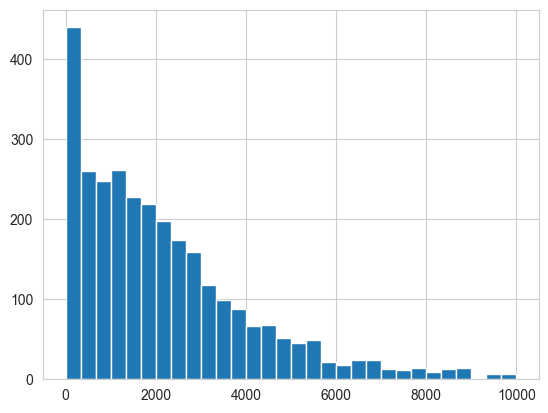

In [149]:
# histogram of number of tokens per doc
# 1 count the number of tokens in each doc
# 2 plot the histogram
#1
len_docs=[]
for doc in tokenized_docs:
    len_doc=0
    for sentence in doc:
        # count the non zero elements
        len_doc+=len(sentence[sentence!=0])
    len_docs.append(len_doc)
#2
import matplotlib.pyplot as plt
len_docs=np.array(len_docs)
plt.hist(len_docs, bins=30, range=(0, 10000))
plt.show()



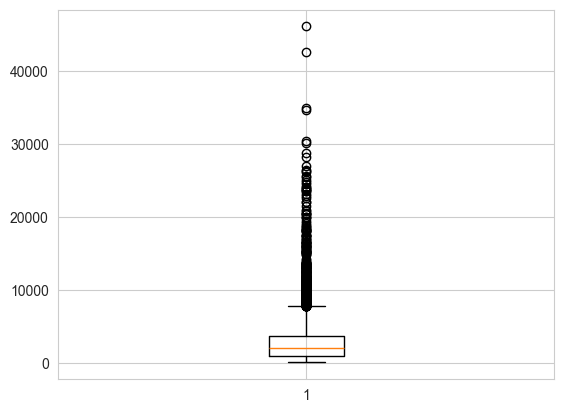

In [87]:
# box plot
plt.boxplot(len_docs)
plt.show()

# Do The same for the dev and test set

In [94]:
documents = df_dev['text'][0:]

tokenized_docs=[]
for document in documents:
    tokenized_docs.append( tokenize_document(document, tokenizer) )
df_dev['tokenized_text'] = tokenized_docs

In [95]:
documents = df_test['text'][0:]
tokenized_docs=[]
for document in documents:
    tokenized_docs.append( tokenize_document(document, tokenizer) )
df_test['tokenized_text'] = tokenized_docs

In [96]:
# save the tokenized datasets
df_train.to_pickle('df_train_tokenized.pkl')
df_dev.to_pickle('df_dev_tokenized.pkl')
df_test.to_pickle('df_test_tokenized.pkl')

In [113]:
# load the tokenized datasets
df_train = pd.read_pickle('df_train_tokenized.pkl')
df_dev = pd.read_pickle('df_dev_tokenized.pkl')
df_test = pd.read_pickle('df_test_tokenized.pkl')

In [114]:
# add attention masks
from tqdm import tqdm
for i, doc in tqdm(enumerate(df_train['tokenized_text'])):
    for j, sentence in enumerate(doc):
        attention_mask = torch.zeros_like(sentence)
        attention_mask[sentence!=0] = 1
        df_train['tokenized_text'][i][j] = (sentence, attention_mask)
df_train['input_ids'] = df_train['tokenized_text'].apply(lambda x: [sentence[0] for sentence in x])
df_train['attention_mask'] = df_train['tokenized_text'].apply(lambda x: [sentence[1] for sentence in x])
#delete tokenized_text
df_train.drop(columns=['tokenized_text'], inplace=True)

7100it [00:05, 1333.74it/s]


In [119]:
# same for dev and test
# add attention masks
from tqdm import tqdm
for i, doc in tqdm(enumerate(df_dev['tokenized_text'])):
    for j, sentence in enumerate(doc):
        attention_mask = torch.zeros_like(sentence)
        attention_mask[sentence!=0] = 1
        df_dev['tokenized_text'][i][j] = (sentence, attention_mask)
df_dev['input_ids'] = df_dev['tokenized_text'].apply(lambda x: [sentence[0] for sentence in x])
df_dev['attention_mask'] = df_dev['tokenized_text'].apply(lambda x: [sentence[1] for sentence in x])
df_dev.drop(columns=['tokenized_text'], inplace=True)

1380it [00:00, 1837.92it/s]


In [122]:
# same for test
# add attention masks
from tqdm import tqdm
for i, doc in tqdm(enumerate(df_test['tokenized_text'])):
    for j, sentence in enumerate(doc):
        attention_mask = torch.zeros_like(sentence)
        attention_mask[sentence!=0] = 1
        df_test['tokenized_text'][i][j] = (sentence, attention_mask)
df_test['input_ids'] = df_test['tokenized_text'].apply(lambda x: [sentence[0] for sentence in x])
df_test['attention_mask'] = df_test['tokenized_text'].apply(lambda x: [sentence[1] for sentence in x])
df_test.drop(columns=['tokenized_text'], inplace=True)

2998it [00:01, 2200.48it/s]


In [123]:
# save the tokenized datasets
df_train.to_pickle('df_train_tokenized.pkl')
df_dev.to_pickle('df_dev_tokenized.pkl')
df_test.to_pickle('df_test_tokenized.pkl')

In [125]:
bert= transformers.BertModel.from_pretrained('bert-base-uncased')

In [126]:
# check the output of the bert model
output = bert(input_ids=df_train['input_ids'][0][0], attention_mask=df_train['attention_mask'][0][0])

In [129]:
output['last_hidden_state'].shape

torch.Size([1, 512, 768])